# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage as sk
import numpy as np
import cv2 as cv

In [2]:
path = './whale_tail/test_image_'

## 1. Считаем данные.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.41it/s]


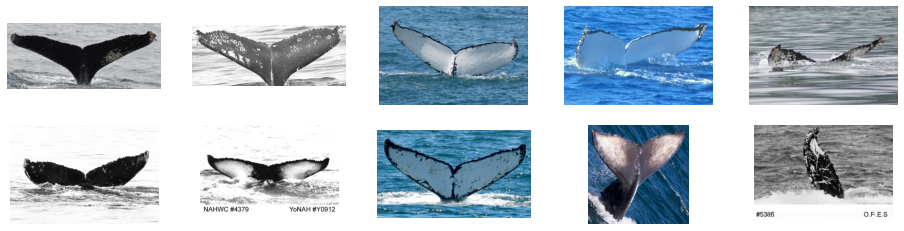

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(16, 4))
axes = axes.ravel()

indicies = np.array([0, 1, 2, 3, 7, 8, 9, 10, 11, 12], dtype=np.uint8)
images = []

for i in tqdm(range(indicies.size)):
    
    ind = indicies[i]
    path_image = f'{path}0{ind}.jpg' if ind < 10 else f'{path}{ind}.jpg'
    
    image = cv.imread(path_image)
    image = cv.cvtColor(image, code=cv.COLOR_BGR2RGB)
    images.append(image)
    
    axes[i].imshow(image)
    axes[i].axis('off')

**Выводы:** мы имеем разнородные данные(RGB и градации серого). Нужно попытаться их унифицировать. 

## 2. Посмотрим на распределения яркости. 

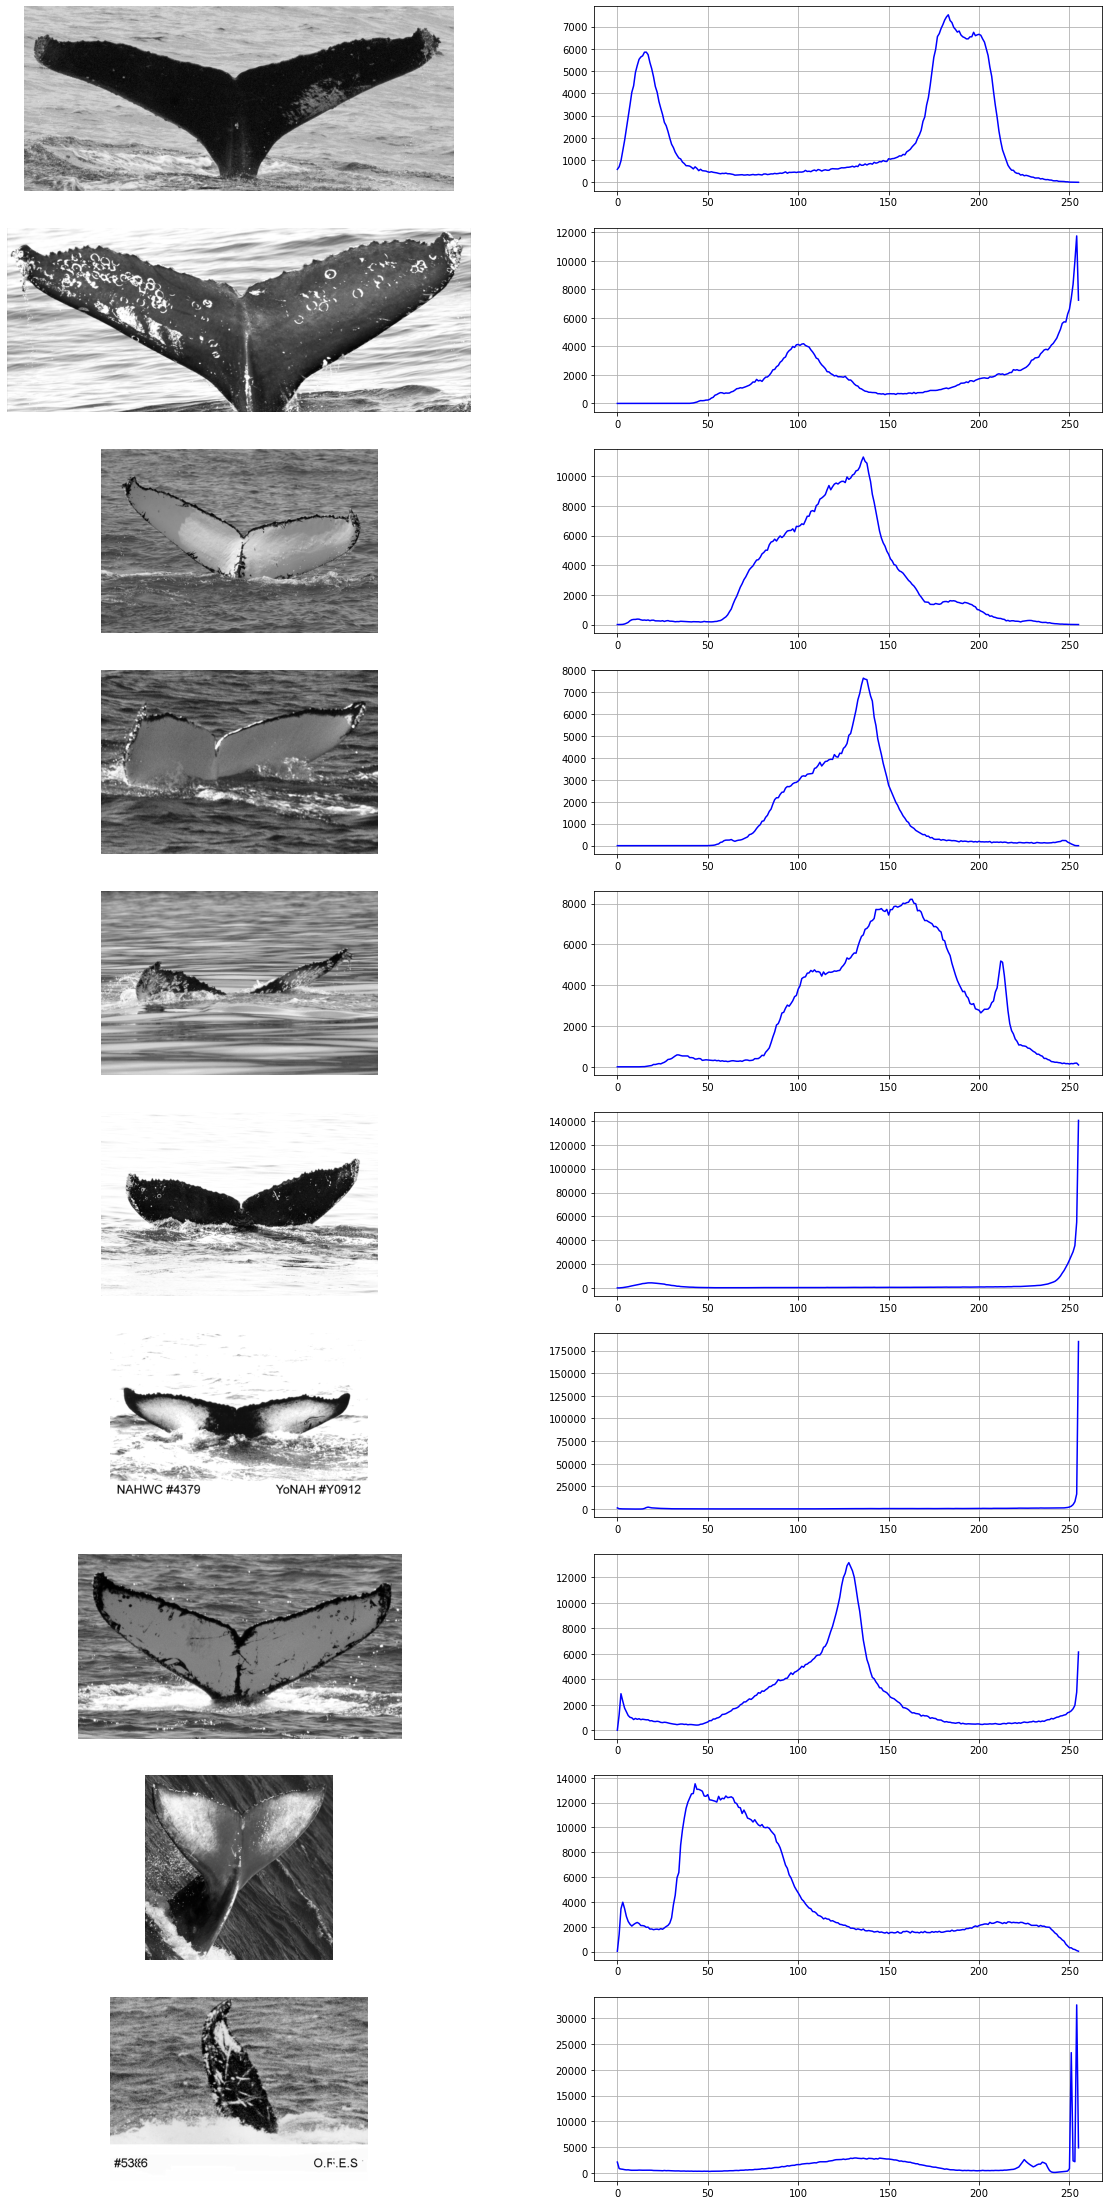

In [4]:
fig, axes = plt.subplots(indicies.size, 2, figsize=(20, 40))
axes = axes.ravel()

for i, image in enumerate(images):
    
    image_gray = cv.cvtColor(image, code=cv.COLOR_RGB2GRAY)
    
    hist, _ = np.histogram(image_gray, bins=256, range=(0, 255))
    
    axes[i * 2].imshow(image_gray, cmap='gray')
    axes[i * 2].axis('off')
    
    axes[i * 2 + 1].plot(hist, c='b')
    axes[i * 2 + 1].grid()
    
plt.show()

## 3. Решим частный случай задачи.

Исследование данных дало следующий результат: часть изображения обладают двухмодальной диаграммой интенсивности. 

Для корректной работы нашего алгоритма будем предполагать, что все входные изображения обладают этим свойстом. Также предположим следующее: хвост всегда ориентирован вверх так, что кончики хвостового плавника являются наименее удалёнными точками от верхнего края изображения, по отношению к остальным точкам хвоста. И финальное предположение состоит в том, что хвост существенно темнее фона.

Данным условиям удовлетворяют изображения: 0, 1, 8, 9.

В данных предположениях можно сформулировать следующий **алгоритм**:

In [5]:
def get_tail_mask(image_gray, kernel_blur1, kernel_blur2,
                  kernel_erode, kernel_dilate, iter_amount):
    """
    Function to get tail binary mask by applying Gaussian blur
    and morphological operations
    
    :param image_gray: numpy ndarray (M, N) - image in grayscale
    :param kernel_blur1: kernel to blur original image
                         tuple (odd int, odd int)
    :param kernel_blur2: kernel to blur binarized image
                         tuple (odd int, odd int)
    :param kernel_erode: kernel to erode binarized image
                         tuple (odd int, odd int)
    :param kernel_dilate: kernel to dilate binarized image
                          tuple (odd int, odd int)
    :param iter_amount: number of iterations for opening
    
    :return: 2-dim numpy ndarray - binary mask of tail
    
    """
    
    image_blured = cv.GaussianBlur(image_gray, kernel_blur1, 0)
    _, binarized = cv.threshold(image_blured, 0, 1, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    mask = cv.GaussianBlur(binarized, kernel_blur2, 0)
    mask = cv.erode(mask, kernel_erode, iter_amount)
    mask = cv.dilate(mask, kernel_dilate, iter_amount)
    
    return mask

In [6]:
def detect_support_points(mask):
    """
    This function detect support points of mask
    
    :param mask: 2-dim numpy ndarray - binary mask of tail
    
    :return: 2-dim numpy array (3, 2) - array of support points
    
    """
    
    y, x = np.where(mask > 0)
    
    points = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
    points = points.astype(np.float32)

    left_top = np.array([0, 0], dtype=points.dtype)
    right_top = np.array((mask.shape[1] - 1, 0),
                         dtype=np.float32)

    dists_left = np.linalg.norm(points - left_top, axis=1)
    dists_right = np.linalg.norm(points - right_top, axis=1)
    dists_mid = np.abs(dists_left - dists_right)

    tail_left = points[dists_left.argmin()]
    tail_right = points[dists_right.argmin()]
    tail_mid = points[dists_mid.argmin()]

    return np.vstack((tail_left, tail_mid, tail_right))

In [7]:
def get_tail_image(image):
    
    """
    This function cut tail from the image rotate and scale
    it if it is needed
    
    :param image: 3-dim numpy array (M, N, 3) - RGB image
    
    :return: 3-dim numpy array (500, 1001, 3) - RGB image of tail
    
    """
    
    template_points = np.array([[49, 80], [500, 400], [950, 80]], 
                               dtype=np.float32)
    template_shape = (1001, 500)
    
    image_gray = cv.cvtColor(image, code=cv.COLOR_RGB2GRAY)
    mask = get_tail_mask(image_gray, (35, 35), (55, 55),
                        (55, 55), (55, 55), 15)
    
    support_points = detect_support_points(mask)
    
    matrix = cv.getAffineTransform(support_points, template_points)
    image_masked = mask[..., np.newaxis] * image
    
    return cv.warpAffine(image_masked, matrix, template_shape)

**Решение:**

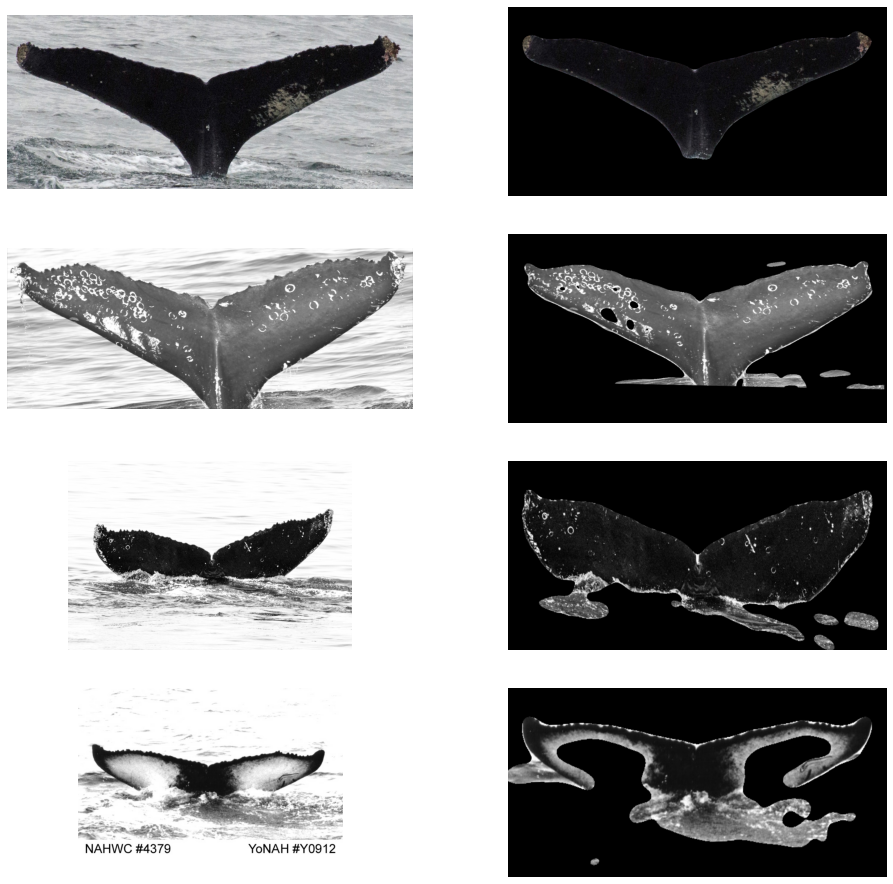

In [8]:
indicies = np.array([0, 1, 8, 9], dtype=np.uint8)

fig, axes = plt.subplots(indicies.size, 2, figsize=(16, 16))
axes = axes.ravel()

for i, ind in enumerate(indicies):
    
    path_image = f'{path}0{ind}.jpg' if ind < 10 else f'{path}{ind}.jpg'
    
    image = cv.imread(path_image)
    image = cv.cvtColor(image, code=cv.COLOR_BGR2RGB)
    
    transformed = get_tail_image(image)
    
    axes[i * 2].imshow(image)
    axes[i * 2 + 1].imshow(transformed)
    
    axes[i * 2].axis('off')
    axes[i * 2 + 1].axis('off')
    
plt.show()